In [1]:
import numpy as np
from scipy.optimize import lsq_linear
from scipy.optimize import curve_fit
from scipy.odr import *

from astropy.coordinates import SkyCoord
from astropy.time import Time
from skyfield.api import load

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams, style
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

In [2]:
#---------------------------------------
# Input some parameters from parm_env.ipynb
#---------------------------------------
%run parm_env.ipynb

['Q' 'K' 'K' 'Ka' 'B7' 'B6' 'B3' 'B4']


### Define the function

In [3]:
def cal_radec(ra_ini_deg, dec_ini_deg, ra_0_deg, dec_0_deg, prop_ra, prop_dec, prllx, time_jd, time_diff):
    
    '''
    Purpose:
    calculate the ra & dec from the original guessing ra_ini & dec_ini
    
    Input:
    - ra_ini_deg        [float]: Initial Guess: Right Ascension [deg]
    - dec_ini_deg       [float]: Initial Guess: Declination [deg]
    - ra_0 _deg         [float]: Fitting result: Right Ascension [deg]
    - dec_0_deg         [float]: Fitting result: Declination [deg]
    - prop_ra           [float]: Proper motion in the direction of ra [mas yr-1]
    - prop_dec          [float]: Proper motion in the direction of dec [mas yr-1]
    - prllx             [float]: Parallax [mas yr-1]
    - time_jd           [float]: Time of the observation [Julian day]
    - time_diff         [float]: Time different: obs. of Fitting & Initial Guess [yr]
    
    
    Return:
    - ra_fin            [float]: Finial value: Right Ascension [deg]
    - dec_fin           [float]: Finial value: Declination [deg]
    
    '''
    
    # transfer the unit
    prllx_deg    = mas2deg(prllx)
    prop_ra_deg  = mas2deg(prop_ra)
    prop_dec_deg = mas2deg(prop_dec)
    
    # get the projection over ra and dec of the parallactic eclipse (Seidelmann 1992)
    f_ra, f_dec = get_project_parallactic(ra_ini_deg, dec_ini_deg, time_jd)
    
    ra_fin_deg  = ra_0_deg  + prop_ra_deg*time_diff  + prllx_deg*f_ra
    dec_fin_deg = dec_0_deg + prop_dec_deg*time_diff + prllx_deg*f_dec
    
    return ra_fin_deg, dec_fin_deg



def get_radec(ra_ini_deg, dec_ini_deg, ra_0_deg, dec_0_deg, \
             prop_ra, prop_dec, prllx, time_ini_yr, time_fin_yr, time_num, epsilon= 1e-20):
    
    '''
    Purpose:
    Get the ra & dec from the original guessing ra_ini & dec_ini, 
    and stop at the |ra_fin - ra_ini| < err & |dec_fin - dec_ini| < err
    
    Input:
    - ra_ini_deg        [float]: Initial Guess: Right Ascension [deg]
    - dec_ini_deg       [float]: Initial Guess: Declination [deg]
    - ra_0_deg          [float]: Fitting result: Right Ascension [deg]
    - dec_0_deg         [float]: Fitting result: Declination [deg]
    - prop_ra           [float]: Proper motion in the direction of ra [mas yr-1]
    - prop_dec          [float]: Proper motion in the direction of dec [mas yr-1]
    - prllx             [float]: Parallax [mas yr-1]
    - time_ini_yr       [float]: Initial time [yr]
    - time_fin_yr       [float]: Final time [yr]
    - time_num            [int]: Number of time interval bwt ini. & fin. time [#]
    - epsilon           [float]: error
       
    
    Return:
    - ra_deg_plot_arr   [float]: Finial value: Right Ascension [deg]
    - dec_deg_plot_arr  [float]: Finial value: Declination [deg]
    '''
    
    # create Time list [yr]
    time_yr_list = np.linspace(time_ini_yr, time_fin_yr, time_num)    
    
    # create empty lists
    ra_deg_plot_list  = []
    dec_deg_plot_list = []
    
    for i, time_yr in enumerate(time_yr_list):
        
        # Time
        time_jd      = Time(time_yr, format='decimalyear').jd   # observation time [Julian day]
        time_diff_yr = time_yr - time_yr_std                    # Time interval [yr]
    
    
        # set the initial different ra & dec as 100
        ra_diff_mas  = 100.
        dec_diff_mas = 100.
        
        # get the ra & dec with parallax
        while ra_diff_mas > epsilon and dec_diff_mas > epsilon:

            # get the ra & dec from the function & input guessing ra & dec
            ra_fin_deg, dec_fin_deg = cal_radec(ra_ini_deg, dec_ini_deg, ra_0_deg, dec_0_deg, \
                                                prop_ra, prop_dec, prllx, time_jd, time_diff_yr)

            # the difference between final & input ra, dec
            ra_diff_mas  = np.abs(deg2mas(ra_fin_deg - ra_ini_deg))
            dec_diff_mas = np.abs(deg2mas(dec_fin_deg - dec_ini_deg))

            # replace the ra & dec using the result from the cal_radec function 
            ra_ini_deg   = ra_fin_deg
            dec_ini_deg  = dec_fin_deg


        # add the finial ra & dec to list
        ra_deg_plot_list.append(ra_fin_deg)
        dec_deg_plot_list.append(dec_fin_deg)
    
        # refresh the initial ra & dec
        ra_ini_deg   = ra_fin_deg
        dec_ini_deg  = dec_fin_deg
    
    # convert the list to np.array
    ra_deg_plot_arr  = np.array(ra_deg_plot_list)
    dec_deg_plot_arr = np.array(dec_deg_plot_list)
    
    
    return ra_deg_plot_arr, dec_deg_plot_arr

### Fitting the Proper Motion with the parallax

$\alpha(t)$ = $\alpha_{0}$  + $\mu_{\alpha}$ cos$\delta$ * $(t - t_{0}$) +  $\pi$$f_{\alpha}$($\alpha(t)$, $\delta(t)$, $t$)

$\delta(t)$ = $\delta_{0}$  + $\mu_{\delta}$ $\hspace{8.5mm}$ *  $(t - t_{0}$) +  $\pi$$f_{\delta}$($\alpha(t)$, $\delta(t)$, $t$)

$f_{\alpha}$($\alpha(t)$, $\delta(t)$, $t$) = $f_{\alpha}$($\alpha$, $\delta$, $t$) =  ($X \sin\alpha - Y \cos\alpha$) $/ \cos\delta$

$f_{\delta}$($\alpha(t)$, $\delta(t)$, $t$) = $f_{\delta}$($\alpha$, $\delta$, $t$) = $X \cos\alpha\sin\delta + Y \sin\alpha\sin\delta - Z \cos\delta$

- ($f_{\alpha}, f_{\delta}$): the projections of the parallactic ellipse [au] 

- ($X$, $Y$, $Z$): barycentric coordinates of the Earth [au], time dependent

---

y $\hspace{37.5mm}$ = a $\hspace{10.5mm}$ * x $\hspace{9mm}$ + b

$\alpha(t) - \pi$$f_{\alpha}$($\alpha(t)$, $\delta(t)$, $t$) = $\mu_{\alpha}$ cos$\delta$ * $(t - t_{0}$) + $\alpha_{0}$

$\delta(t) - \pi$$f_{\delta}$($\alpha(t)$, $\delta(t)$, $t$) = $\mu_{\delta}$ $\hspace{8.5mm}$ *  $(t - t_{0}$) + $\delta_{0}$

In [4]:
# y: corvert the unit of ra and dec from deg to mas
ra_mas_arr          = deg2mas(ra_deg_arr)                 # Right Ascension [mas]
dec_mas_arr         = deg2mas(dec_deg_arr)                # Declination     [mas]
radec_err_mas_arr   = deg2mas(radec_err_deg_arr)          # Uncertainties of RA & Dec [mas]

f_ra_arr, f_dec_arr = get_project_parallactic(ra_deg_arr, dec_deg_arr, time_jd_arr)
prllx_ra_mas_arr    = prllx * f_ra_arr                    # parallax in the direction of ra  [mas]
prllx_dec_mas_arr   = prllx * f_dec_arr                   # parallax in the direction of dec [mas]

ra_minus_prllx_mas_arr  = ra_mas_arr - prllx_ra_mas_arr   # ra  - parallax_ra  [mas] 
dec_minus_prllx_mas_arr = dec_mas_arr - prllx_dec_mas_arr # dec - parallax_dec [mas] 

# x: calculate the observational time difference [yr]
time_diff_yr_arr  = time_yr_arr - time_yr_std

#----------------------------------------------------
# Set the y & x for the linear regression
y_ra_arr          = split_Qband(ra_minus_prllx_mas_arr)          # RA(t) - prllx_ra        [mas]
y_err_ra_arr      = split_Qband(radec_err_mas_arr)               # Uncertainties of RA(t)  [mas]
x_ra_arr          = split_Qband(time_diff_yr_arr)                # t - t_0   [yr]

y_dec_arr         = split_Qband(dec_minus_prllx_mas_arr)         # Dec(t) - prllx_dec      [mas]
y_err_dec_arr     = split_Qband(radec_err_mas_arr)               # Uncertainties of Dec(t) [mas]
x_dec_arr         = split_Qband(time_diff_yr_arr)                # t - t_0   [yr]

In [5]:
%%time
###--------------------------------------------------
# linear regression
# Python package numpy.polyfit with order = 1
z_ra_arr  = np.polyfit(x_ra_arr,  y_ra_arr, 1)  # Proper_motion_ra[mas yr-1] ; ra_0[mas]
z_dec_arr = np.polyfit(x_dec_arr, y_dec_arr, 1) # Proper_motion_dec[mas yr-1]; dec_0[mas]

CPU times: user 719 µs, sys: 165 µs, total: 884 µs
Wall time: 903 µs


In [6]:
# Observational time [year]
t0_yr      = time_yr_arr[1]
tf_yr      = time_yr_arr[-1]
t_std_yr   = time_yr_std

# Time different [yr] from the first fitting plot (JVLA K) btw the reference (ALMA B4)
t0_diff_yr = t0_yr - t_std_yr
tf_diff_yr = tf_yr - t_std_yr

# parallax_ra, parallax_dec
prllx_ra_sec_arr   = ra_arcs2sec(prllx_ra_mas_arr/3600.) * np.cos(np.deg2rad(dec_deg_std))
prllx_dec_arcs_arr = prllx_dec_mas_arr/3600.

# uncertainty for ra
err_arcs_arr    = radec_err_arcs_arr
ra_err_sec_arr  = ra_arcs2sec(radec_err_arcs_arr)
    
# obs: ra, dec - parallax
ra_minus_prllx_deg_arr  = mas2deg(ra_minus_prllx_mas_arr)   # [deg]
dec_minus_prllx_deg_arr = mas2deg(dec_minus_prllx_mas_arr)  # [deg]

# [sec], [arcs]
ra_minus_prllx_sec_arr, dec_minus_prllx_arcs_arr = \
radec_degdeg2secacrs_arr(ra_minus_prllx_deg_arr, dec_minus_prllx_deg_arr)  

#----------------------------------------------------
# ra_B4_fit & dec_B4_fit
# y = ax + b

# a: proper_ra, proper_dec
proper_ra_fit_masyr   = z_ra_arr[0]        # proper motion (ra)  [mas yr-1]
proper_dec_fit_masyr  = z_dec_arr[0]       # proper motion (dec) [mas yr-1]
proper_ra_fit_secyr   = ra_arcs2sec(proper_ra_fit_masyr* 1e-3)
proper_dec_fit_arcsyr = proper_dec_fit_masyr * 1e-3

# b: ra_0, dec_0
ra_0_fit_mas   = z_ra_arr[1]
dec_0_fit_mas  = z_dec_arr[1]
ra_0_fit_deg   = mas2deg(ra_0_fit_mas)
dec_0_fit_deg  = mas2deg(dec_0_fit_mas)
ra_0_fit_sec, dec_0_fit_arcs = radec_degdeg2secacrs(ra_0_fit_deg, dec_0_fit_deg)

In [7]:
#----------------------------------------------------
# Fitting result
print ('#------------------')
print ('Fitting result:')
# the proper motion [mas yr-1]
print ('Proper motion in RA  = {0} \t[mas yr-1]'.format(proper_ra_fit_masyr))
print ('Proper motion in Dec = {0} \t[mas yr-1]'.format(proper_dec_fit_masyr))
print ('')

#----------------------------------------------------
# The position of the ALMA Band 4 without parallax [mas]
print ('#------------------')
print ('(1) The position of the ALMA Band 4 w/o parallax (i.e., fitting result)')
print ('RA  = {0} \t[mas]'.format(ra_0_fit_mas))
print ('Dec = {0} \t[mas]'.format(dec_0_fit_mas))
print ('')

# Compare the position of the ALMA Band 4 with parallax [mas]
print ('(2) The position of the ALMA Band 4 w/  parallax (i.e., obs.)')
print ('RA  = {0} \t[mas]'.format(ra_mas_std))
print ('Dec = {0} \t[mas]'.format(dec_mas_std))
print ('')

#----------------------------------------------------
# The difference of the ra_0, ra_std & dec_0, dec_std
ra_0_diff_mas         = ra_mas_std  - ra_0_fit_mas
dec_0_diff_mas        = dec_mas_std - dec_0_fit_mas
mag_0_diff_mas        = np.sqrt(ra_0_diff_mas**2 + dec_0_diff_mas**2)
 
# Get the projection of the Earth to calculate the parallax
f_ra_std, f_dec_std   = get_project_parallactic(ra_deg_std, dec_deg_std, time_jd_std)

ra_obs_prllx_mas     = f_ra_std  * prllx
dec_obs_prllx_mas    = f_dec_std * prllx
mag_obs_prllx_mas    = np.sqrt(ra_obs_prllx_mas**2 + dec_obs_prllx_mas**2)

print ('#------------------')
print ('The difference of the ALMA Band 4 w/ & w/o parallax')
print ('(1) From fitting result')
print ('RA        = {0} \t[mas]'.format(ra_0_diff_mas))
print ('Dec       = {0} \t[mas]'.format(dec_0_diff_mas))
print ('Magnitude = {0} \t[mas]'.format(mag_0_diff_mas))
print ('')
print ('(2) From the observation (i.e, f_ra, f_dec * parallax)')
print ('RA        = {0} \t[mas]'.format(ra_obs_prllx_mas))
print ('Dec       = {0} \t[mas]'.format(dec_obs_prllx_mas))
print ('Magnitude = {0} \t[mas]'.format(mag_obs_prllx_mas))
print ('(Note: the position uncertainty of ALMA Band 4 is 3 mas)')
print ('')

#------------------
Fitting result:
Proper motion in RA  = 11.07278944710277 	[mas yr-1]
Proper motion in Dec = -12.526704650978337 	[mas yr-1]

#------------------
(1) The position of the ALMA Band 4 w/o parallax (i.e., fitting result)
RA  = 188256464.83327627 	[mas]
Dec = 112412040.02092116 	[mas]

(2) The position of the ALMA Band 4 w/  parallax (i.e., obs.)
RA  = 188256465.0 	[mas]
Dec = 112412040.0 	[mas]

#------------------
The difference of the ALMA Band 4 w/ & w/o parallax
(1) From fitting result
RA        = 0.16672372817993164 	[mas]
Dec       = -0.02092115581035614 	[mas]
Magnitude = 0.16803123608025067 	[mas]

(2) From the observation (i.e, f_ra, f_dec * parallax)
RA        = 3.0346435259302584 	[mas]
Dec       = 0.33531491940189806 	[mas]
Magnitude = 3.0531127435199528 	[mas]
(Note: the position uncertainty of ALMA Band 4 is 3 mas)



### Polt the fitting result (with papallax)

In [8]:
%%time
# Input parameter:the initial condition (ALMA B4)
i = -1
ra_ini_deg  = ra_deg_arr[i]       # ra  [deg]
dec_ini_deg = dec_deg_arr[i]      # dec [deg]
time_ini_yr = time_yr_arr[i] + 2  # year start  [yr]
time_fin_yr = time_yr_arr[0] - 2  # year finish [yr]
time_num    = 100                 # Time number btw time_ini & time_fin [#]
time_fit_yr_list = np.linspace(time_ini_yr, time_fin_yr, time_num)
time_fit_diff_yr_list = time_fit_yr_list - time_yr_arr[i]

#----------------------------------------------------
# (1) with parallax
# Obtain the fitting ra & dec with parallax
ra_fit_deg_arr, dec_fit_deg_arr = get_radec(ra_ini_deg, dec_ini_deg, ra_0_fit_deg, dec_0_fit_deg,
                                            proper_ra_fit_masyr, proper_dec_fit_masyr, prllx, \
                                            time_ini_yr, time_fin_yr, time_num, epsilon= 1e-50)
# Convert the unit from deg to mas
ra_fit_mas_arr  = deg2mas(ra_fit_deg_arr)
dec_fit_mas_arr = deg2mas(dec_fit_deg_arr)

# convert the unit of ra, dec from deg to sec, arcsec
ra_fit_sec_arr, dec_fit_arcs_arr = \
radec_degdeg2secacrs_arr(ra_fit_deg_arr, dec_fit_deg_arr)

#----------------------------------------------------
# (2) without parallax
# Obtain the fitting ra & dec without parallax: e.g., ra-prllx_ra = ra (prllx_ra =0)
ra_fit_wo_prllx_mas_arr       = proper_ra_fit_masyr  * time_fit_diff_yr_list + ra_0_fit_mas
dec_fit_wo_prllx_mas_arr      = proper_dec_fit_masyr * time_fit_diff_yr_list + dec_0_fit_mas
ra_fit_wo_prllx_deg_arr       = mas2deg(ra_fit_wo_prllx_mas_arr)
dec_fit_wo_prllx_deg_arr      = mas2deg(dec_fit_wo_prllx_mas_arr)

# convert the unit of ra, dec from deg to sec, arcsec
ra_fit_wo_prllx_sec_arr, dec_fit_wo_prllx_arcs_arr = \
radec_degdeg2secacrs_arr(ra_fit_wo_prllx_deg_arr, dec_fit_wo_prllx_deg_arr)

CPU times: user 2.51 s, sys: 196 ms, total: 2.7 s
Wall time: 5.63 s


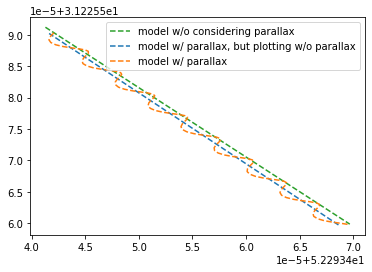

In [9]:
# plot the figure

#----------------------------------------------------
# fitting without pallax
t = np.linspace(-7, 2, 10)

ra_fit_mas_t       = 11.346538177766496  *t + 188256468.08834362
dec_fit_mas_t      = -12.550489771771408 *t + 112412040.51142894
ra_fit_deg_t       = mas2deg(ra_fit_mas_t)
dec_fit_deg_t      = mas2deg(dec_fit_mas_t)

plt.plot(ra_fit_deg_t, dec_fit_deg_t, '--', color='tab:green', label='model w/o considering parallax')

#----------------------------------------------------
# fitting with pallax, plotting without parallax

plt.plot(ra_fit_wo_prllx_deg_arr, dec_fit_wo_prllx_deg_arr, '--', color='tab:blue', label='model w/ parallax, but plotting w/o parallax')

#----------------------------------------------------
# fitting with pallax, plotting with parallax

plt.plot(ra_fit_deg_arr, dec_fit_deg_arr, '--', color='tab:orange', label='model w/ parallax')


plt.legend()
plt.show()

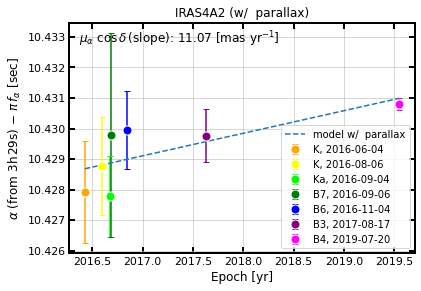

In [10]:
# Plot the fitting result (Proper_RA*cos(dec) v.s. Time)
# a = proper_ra * cos(dec)
fig = plt.figure()
ax  = fig.add_axes([0.14,0.12,0.8,0.8]) # left, bottom, width, height (range 0 to 1)

#----------------------------------------------------
# Plot the observations
for i, elm in enumerate(x_ra_arr):
    
    i_shift = i+1
    
    # x: t - t0 [yr]
    time_yr       = time_yr_arr[i_shift]
    
    # y: RA(t) - parallax_ra [sec]
    ra_minus_prllx_sec = ra_minus_prllx_sec_arr[i_shift]    
    # uncertainty for ra [sec]
    ra_err_sec       = ra_err_sec_arr[i_shift]
 
    # plot
    ax.errorbar(x    = time_yr, \
                y    = ra_minus_prllx_sec, \
                yerr = ra_err_sec, \
                fmt='o', color = color_list[i_shift], \
                alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                label=Band_arr[i_shift]+', '+time_yms_arr[i_shift])

#----------------------------------------------------
# plot the fitting result

# Time [yr]
t = np.linspace(t0_diff_yr, tf_diff_yr, 20)
t_shift = t + time_yr_std

# y = a                  * x + b
# y = proper_ra*cos(dec) * x + ra_0 = RA(t) - parallax_ra [sec]
ra_fit_minus_prllx_sec = proper_ra_fit_secyr*t + ra_0_fit_sec
slope_ra_txt = float('%.2f' % z_ra_arr[0])

# plot the fitting result
ax.plot(t_shift, ra_fit_minus_prllx_sec, '--' ,color='tab:blue', label='model w/  parallax')

# Set the figure
# ax.set_title('Proper_ra*cos(dec) v.s. Time', fontsize=12)
ax.set_title('IRAS4A2 (w/  parallax)', fontsize=12)
ax.set_xlabel('Epoch [yr]', fontsize=12)
ax.set_ylabel(r'$\alpha$ (from %sh$\,$%ss) $-$ $\pi\,f_{\alpha}$ [sec]'%(ra_hour_int, ra_minute_int), fontsize=12)
ax.text(0.03, 0.93, r'$\mu_{\alpha}$ $\cos\,\delta\,$(slope): %s [mas yr$^{-1}$]'%(slope_ra_txt), color='black', size=12, \
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

# set the major and minor tickers
# ax.xaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_major_locator(MultipleLocator(30))
# ax.xaxis.set_minor_locator(MultipleLocator(0.02))
# ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(which='major', direction='in', length=6, width=2, labelsize=11, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=11, top=True, right=True)

# set the width of the axes
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

ax.grid(color='silver', alpha=0.8)
ax.legend()

plt.savefig('%s4A2_TimeRA_with_prllx.pdf'%(path_figure))
plt.show()

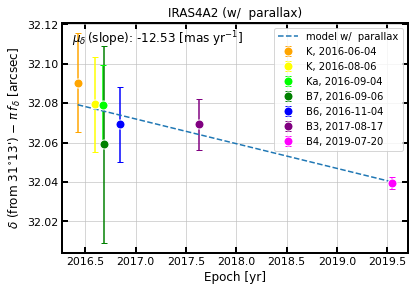

In [11]:
# Plot the fitting result (Proper_Dec v.s. Time)
# a = proper_dec
fig = plt.figure()
ax  = fig.add_axes([0.14,0.12,0.8,0.8]) # left, bottom, width, height (range 0 to 1)

#----------------------------------------------------
# Plot the observations
for i, elm in enumerate(x_dec_arr):
    
    i_shift = i+1
    
    # x: t - t0 [yr]
    time_yr       = time_yr_arr[i_shift]
    
    # y: Dec(t) - parallax_dec [arcs]
    dec_minus_prllx_arcs = dec_minus_prllx_arcs_arr[i_shift]
    # uncertainty for dec [arcs]
    err_arcs      = err_arcs_arr[i_shift]
   
    ax.errorbar(x    = time_yr, \
                y    = dec_minus_prllx_arcs, \
                yerr = err_arcs, \
                fmt='o', color = color_list[i_shift], \
                alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                label=Band_arr[i_shift]+', '+time_yms_arr[i_shift])

#----------------------------------------------------
# plot the fitting result

# Time
t = np.linspace(t0_diff_yr, tf_diff_yr, 20)
t_shift = t + time_yr_std

# y = a          * x + b
# y = proper_dec * x + dec_0
dec_fit_minus_prllx_sec = proper_dec_fit_arcsyr*t + dec_0_fit_arcs
slope_dec_txt  = float('%.2f' % z_dec_arr[0])

# plot the fitting result
ax.plot(t_shift, dec_fit_minus_prllx_sec, '--',color='tab:blue', label='model w/  parallax')

#----------------------------------------------------
# Set the figure
# ax.set_title('Proper_ra*cos(dec) v.s. Time', fontsize=12)
ax.set_title('IRAS4A2 (w/  parallax)', fontsize=12)
ax.set_xlabel('Epoch [yr]', fontsize=12)
ax.set_ylabel(r"$\delta$ (from %s$^{\circ}$%s') $-$ $\pi\,f_{\delta}$ [arcsec]"%(dec_deg_int, dec_arcm_int), fontsize=12)
ax.text(0.03, 0.93, r'$\mu_{\delta}\,$(slope): %s [mas yr$^{-1}$]'%(slope_dec_txt), color='black', size=12, \
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

# set the major and minor tickers
# ax.xaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_major_locator(MultipleLocator(30))
# ax.xaxis.set_minor_locator(MultipleLocator(0.02))
# ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(which='major', direction='in', length=6, width=2, labelsize=11, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=11, top=True, right=True)

# set the width of the axes
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

ax.grid(color='silver', alpha=0.8)
ax.legend()

plt.savefig('%s4A2_TimeDec_with_prllx.pdf'%(path_figure))
plt.show()

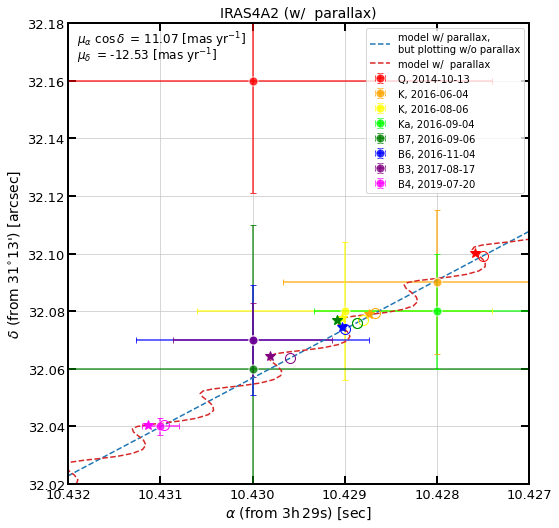

In [12]:
# Plot the fitting result (RA v.s. Dec)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.14,0.12,0.8,0.8]) 

#---------------------------------------
# Plot the observations
for i, band in enumerate(Band_arr):
    
    # x: ra  [sec]
    ra_sec        = ra_s_arr[i]  
    # y: dec [arcs]
    dec_arcs      = dec_s_arr[i]  
    # uncertainty for the coordinate
    err_arcs      = radec_err_arcs_arr[i]
    ra_err_sec    = ra_err_sec_arr[i]
    
    ax.errorbar(x    = ra_sec,\
                y    = dec_arcs,\
                xerr = ra_err_sec,\
                yerr = err_arcs ,\
                fmt='o', color = color_list[i],\
                alpha=0.8, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                label=band+', '+time_yms_arr[i])
    
    #---------------------------------------
    # Plot the fitting result with corresponding observation time     
               
    # find the nearst time from the time_yr_plot_list
    idx, out_value = find_nearest(time_fit_yr_list, time_yr_arr[i])
        
    # (1) without parallax   
    # x: ra(t) - parallax_ra  [sec]
    ra_fit_wo_prllx_sec        = ra_fit_wo_prllx_sec_arr[idx]
    
    # y: dec(t) - parallax_dec [arcs]
    dec_fit_wo_prllx_arcs      = dec_fit_wo_prllx_arcs_arr[idx]
    
    ax.plot(ra_fit_wo_prllx_sec, dec_fit_wo_prllx_arcs, color = color_list[i], \
            marker='o', fillstyle = 'none', markeredgewidth=1, markersize=10, zorder=10) 
    
    #(2)
    # x: ra(t)  [sec]
    ra_fit_sec     = ra_fit_sec_arr[idx]
    # y: dec(t) [arcs]
    dec_fit_arcs   = dec_fit_arcs_arr[idx]
    
    ax.plot(ra_fit_sec, dec_fit_arcs, color = color_list[i], \
            marker='*', fillstyle = 'full', markeredgewidth=1, markersize=10, zorder=10)

#---------------------------------------
# plot the fitting result

# plotting without parallax
plt.plot(ra_fit_wo_prllx_sec_arr, dec_fit_wo_prllx_arcs_arr, '--', color='tab:blue', label='model w/ parallax, \nbut plotting w/o parallax')

# plotting with parallax
ax.plot(ra_fit_sec_arr, dec_fit_arcs_arr, '--', color='tab:red', label='model w/  parallax')

#---------------------------------------
# Set the figure
ax.set_title('IRAS4A2 (w/  parallax)', fontsize=14)
ax.set_xlabel(r'$\alpha$ (from %sh$\,$%ss) [sec]'%(ra_hour_int, ra_minute_int), fontsize=14)
ax.set_ylabel(r"$\delta$ (from %s$^{\circ}$%s') [arcsec]"%(dec_deg_int, dec_arcm_int), fontsize=14)
ax.set_xlim(10.432, 10.427)
ax.set_ylim(32.02, 32.18)

ax.text(0.02, 0.965, r'$\mu_{\alpha}$ $\cos\,\delta\,$ = %s [mas yr$^{-1}$]'%(slope_ra_txt), color='black', size=12, \
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.02, 0.93, r'$\mu_{\delta}\,$ = %s [mas yr$^{-1}$]'%(slope_dec_txt), color='black', size=12, \
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

ax.tick_params(which='major', direction='in', length=8, width=2, labelsize=13, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=13, top=True, right=True)

# set the width of the axes
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.grid(color='silver', alpha=0.8)
ax.legend(loc='upper right')

plt.savefig('%s4A2_radec_with_prllx.pdf'%(path_figure))
plt.show()

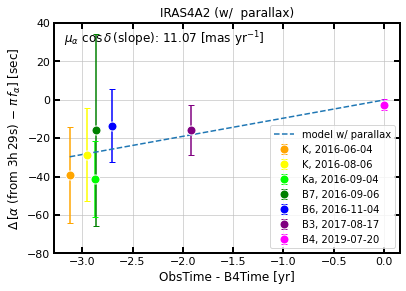

In [13]:
# Plot the fitting result (Proper_RA*cos(dec) v.s. Time)
# a = proper_ra * cos(dec)
fig = plt.figure()
ax  = fig.add_axes([0.14,0.12,0.8,0.8]) # left, bottom, width, height (range 0 to 1)

#----------------------------------------------------
# Plot the observations
# x: t - t0
# y: RA(t)
for i, elm in enumerate(x_ra_arr):
    
    i_shift = i+1
    y_ra_diff = (y_ra_arr[i] - ra_mas_std) * np.cos(np.deg2rad(dec_deg_std))
    
    ax.errorbar(x    = x_ra_arr[i], \
                y    = y_ra_diff, \
                yerr = y_err_ra_arr[i], \
                fmt='o', color = color_list[i_shift], \
                alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                label=Band_arr[i_shift]+', '+time_yms_arr[i_shift])

#----------------------------------------------------
# plot the fitting result

# Time
t = np.linspace(t0_diff_yr, tf_diff_yr, 20)

# y = a                  * x + b
# y = proper_ra*cos(dec) * x + ra_0
y_ra_fit      = z_ra_arr[0]*t + z_ra_arr[1]
y_ra_fit_diff = (y_ra_fit - ra_mas_std)* np.cos(np.deg2rad(dec_deg_std))

# plot the fitting result
ax.plot(t, y_ra_fit_diff, '--', color='tab:blue', label='model w/ parallax')

# Set the figure
# ax.set_title('Proper_ra*cos(dec) v.s. Time', fontsize=12)
ax.set_title('IRAS4A2 (w/  parallax)', fontsize=12)
ax.set_xlabel('ObsTime - B4Time [yr]', fontsize=12)
ax.set_ylabel(r'$\Delta\,$[$\alpha$ (from %sh$\,$%ss) $-$ $\pi\,f_{\alpha}$] [sec]'%(ra_hour_int, ra_minute_int), fontsize=12)
ax.text(0.03, 0.93, r'$\mu_{\alpha}$ $\cos\,\delta\,$(slope): %s [mas yr$^{-1}$]'%(slope_ra_txt), color='black', size=12, \
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
#ax.set_xlim(40, -80)
ax.set_ylim(-80, 40)


# set the major and minor tickers
# ax.xaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_major_locator(MultipleLocator(30))
# ax.xaxis.set_minor_locator(MultipleLocator(0.02))
# ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(which='major', direction='in', length=6, width=2, labelsize=11, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=11, top=True, right=True)

# set the width of the axes
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

ax.grid(color='silver', alpha=0.8)
ax.legend()

plt.savefig('%s4A2_TimeRA_with_prllx_mas.pdf'%(path_figure))
plt.show()

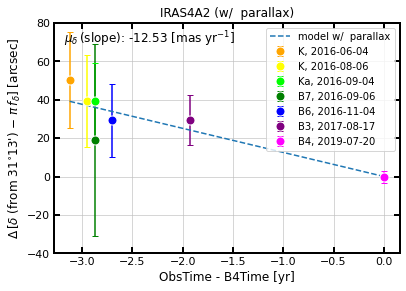

In [14]:
# Plot the fitting result (Proper_Dec v.s. Time)
# a = proper_dec
fig = plt.figure()
ax  = fig.add_axes([0.14,0.12,0.8,0.8]) # left, bottom, width, height (range 0 to 1)

#----------------------------------------------------
# Plot the observations
for i, elm in enumerate(x_dec_arr):
    
    # x: t - t0
    # y: RA(t)    
    i_shift = i+1
    y_dec_diff = y_dec_arr[i] - dec_mas_std
    
    ax.errorbar(x    = x_dec_arr[i], \
                y    = y_dec_diff, \
                yerr = y_err_dec_arr[i], \
                fmt='o', color = color_list[i_shift], \
                alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                label=Band_arr[i_shift]+', '+time_yms_arr[i_shift])

#----------------------------------------------------
# plot the fitting result

# Time
t = np.linspace(t0_diff_yr, tf_diff_yr, 20)

# y = a          * x + b
# y = proper_dec * x + dec_0
y_dec_fit = z_dec_arr[0]*t + z_dec_arr[1]
y_dec_fit_diff = y_dec_fit - dec_mas_std

# plot the fitting result
ax.plot(t, y_dec_fit_diff, '--', color='tab:blue', label='model w/  parallax')

#----------------------------------------------------
# Set the figure
# ax.set_title('Proper_ra*cos(dec) v.s. Time', fontsize=12)
ax.set_title('IRAS4A2 (w/  parallax)', fontsize=12)
ax.set_xlabel('ObsTime - B4Time [yr]', fontsize=12)
ax.set_ylabel(r"$\Delta\,$[$\delta$ (from %s$^{\circ}$%s') $-$ $\pi\,f_{\delta}$] [arcsec]"%(dec_deg_int, dec_arcm_int), fontsize=12)
ax.text(0.03, 0.93, r'$\mu_{\delta}\,$(slope): %s [mas yr$^{-1}$]'%(slope_dec_txt), color='black', size=12, \
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
#ax.set_xlim(40, -80)
ax.set_ylim(-40, 80)

# set the major and minor tickers
# ax.xaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_major_locator(MultipleLocator(30))
# ax.xaxis.set_minor_locator(MultipleLocator(0.02))
# ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(which='major', direction='in', length=6, width=2, labelsize=11, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=11, top=True, right=True)

# set the width of the axes
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

ax.grid(color='silver', alpha=0.8)
ax.legend()

plt.savefig('%s4A2_TimeDec_with_prllx_mas.pdf'%(path_figure))
plt.show()

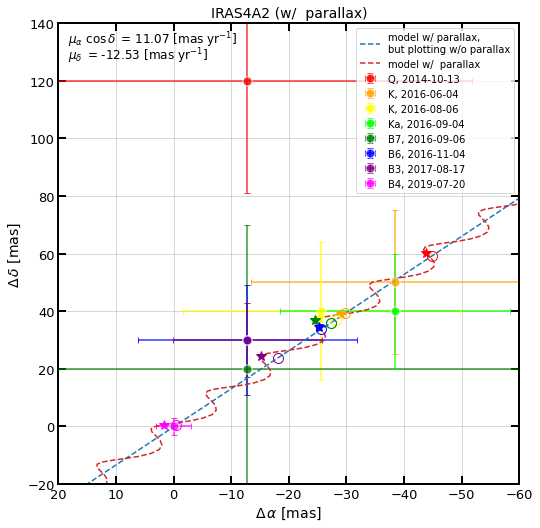

In [15]:
# Plot the fitting result (RA v.s. Dec)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.14,0.12,0.8,0.8]) 

#---------------------------------------
# Plot the observations
for i, band in enumerate(Band_arr):
    
    # ra & dec difference between each and the standard (B4) obs.
    ra_diff_mas  = (ra_mas_arr[i]  - ra_mas_std ) * np.cos(np.deg2rad(dec_deg_std))
    dec_diff_mas = dec_mas_arr[i]  - dec_mas_std
    # uncertainty for the coordinate
    err_mas      = radec_err_mas_arr[i]   
    
    ax.errorbar(x    = ra_diff_mas,\
                y    = dec_diff_mas,\
                xerr = err_mas,\
                yerr = err_mas,\
                fmt='o', color = color_list[i],\
                alpha=0.8, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                label=band+', '+time_yms_arr[i])
    
    #---------------------------------------
    # Plot the fitting result with corresponding observational time 
        
    # find the nearst time from the time_yr_plot_list
    idx, out_value = find_nearest(time_fit_yr_list, time_yr_arr[i])
    
    # (1) without parallax
    # x: ra(t) - parallax_ra  [mas]
    ra_fit_wo_prllx_mas       = ra_fit_wo_prllx_mas_arr[idx]
    ra_fit_wo_prllx_diff_mas  = (ra_fit_wo_prllx_mas - ra_mas_std) * np.cos(np.deg2rad(dec_deg_std))
    
    # y: dec(t) [mas]
    dec_fit_wo_prllx_mas      = dec_fit_wo_prllx_mas_arr[idx]
    dec_fit_wo_prllx_diff_mas = (dec_fit_wo_prllx_mas - dec_mas_std)

    # plot
    ax.plot(ra_fit_wo_prllx_diff_mas, dec_fit_wo_prllx_diff_mas, color = color_list[i], \
            marker='o', fillstyle = 'none', markeredgewidth=1, markersize=10, zorder=10)   
    
    # (2) with parallax
    # x: ra(t)  [mas]
    ra_fit_mas      = ra_fit_mas_arr[idx]
    ra_fit_diff_mas = (ra_fit_mas - ra_mas_std) * np.cos(np.deg2rad(dec_deg_std))
    
    # y: dec(t) [mas]
    dec_fit_mas      = dec_fit_mas_arr[idx]
    dec_fit_diff_mas = dec_fit_mas - dec_mas_std
    
    # plot
    ax.plot(ra_fit_diff_mas, dec_fit_diff_mas, color = color_list[i], \
            marker='*', fillstyle = 'full', markeredgewidth=1, markersize=10, zorder=10)

#---------------------------------------
# plot the fitting result

ra_fit_wo_prllx_diff_mas_arr  = (ra_fit_wo_prllx_mas_arr  - ra_mas_std) * np.cos(np.deg2rad(dec_deg_std))
dec_fit_wo_prllx_diff_mas_arr = dec_fit_wo_prllx_mas_arr  - dec_mas_std
ra_fit_diff_mas_arr           = (ra_fit_mas_arr           - ra_mas_std) * np.cos(np.deg2rad(dec_deg_std))
dec_fit_diff_mas_arr          = dec_fit_mas_arr           - dec_mas_std

# plotting without parallax
plt.plot(ra_fit_wo_prllx_diff_mas_arr, dec_fit_wo_prllx_diff_mas_arr, \
         '--', color='tab:blue', label='model w/ parallax, \nbut plotting w/o parallax')

# plotting with parallax
ax.plot(ra_fit_diff_mas_arr, dec_fit_diff_mas_arr, '--', color='tab:red', label='model w/  parallax')
 
#---------------------------------------
# Set the figure
ax.set_title('IRAS4A2 (w/  parallax)', fontsize=14)
ax.set_xlabel(r'$\Delta\,\alpha$ [mas]', fontsize=14)
ax.set_ylabel(r'$\Delta\,\delta$ [mas]', fontsize=14)
ax.set_xlim(20, -60)
ax.set_ylim(-20, 140)

ax.text(0.02, 0.965, r'$\mu_{\alpha}$ $\cos\,\delta\,$ = %s [mas yr$^{-1}$]'%(slope_ra_txt), color='black', size=12, \
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.02, 0.93, r'$\mu_{\delta}\,$ = %s [mas yr$^{-1}$]'%(slope_dec_txt), color='black', size=12, \
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

ax.tick_params(which='major', direction='in', length=8, width=2, labelsize=13, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=13, top=True, right=True)

# set the width of the axes
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.grid(color='silver', alpha=0.8)
ax.legend(loc='upper right')

plt.savefig('%s4A2_radec_with_prllx_mas.pdf'%(path_figure))
plt.show()

In [16]:
mm1 = SkyCoord('03h29m10.429s', '+31d13m32.08s')
mm2 = SkyCoord('03h29m10.431s', '+31d13m32.04s')

ra_offset  = (mm2.ra - mm1.ra) * np.cos(mm1.dec.to('radian'))
dec_offset = (mm2.dec - mm1.dec)
print (ra_offset.to('arcsec'), dec_offset.to('arcsec'))

0.025654arcsec -0.04arcsec
